# Gọi thư viện cần thiết 

In [1]:
import numpy as np
from PIL import Image, ImageFont, ImageDraw
from PIL.ImageChops import add, subtract, multiply, difference, screen
import PIL.ImageStat as stat
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
from skimage import color, exposure, img_as_float, data
from skimage.transform import SimilarityTransform, warp, swirl
from skimage.util import invert, random_noise, montage
import matplotlib.image as mpimg
import matplotlib.pylab as plt
from scipy.ndimage import affine_transform, zoom
from scipy import misc

# YOLOv2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


def load_conv_bn(buf, start, conv_model, bn_model):
    """ 
    Tải trọng số cho các lớp convolution và batch normalization.
    
    Args:
        buf (np.ndarray): Bộ nhớ chứa trọng số.
        start (int): Chỉ số bắt đầu trong bộ nhớ.
        conv_model (nn.Module): Mô hình lớp convolution.
        bn_model (nn.Module): Mô hình lớp batch normalization.
    
    Returns:
        int: Chỉ số cập nhật sau khi tải trọng số.
    """
    num_w = conv_model.weight.numel()  # Tổng số trọng số trong lớp convolution
    num_b = bn_model.bias.numel()       # Tổng số bias trong lớp batch norm
    
    # Tải các tham số của batch normalization
    bn_model.bias.data.copy_(torch.from_numpy(buf[start: start + num_b])); start += num_b
    bn_model.weight.data.copy_(torch.from_numpy(buf[start: start + num_b])); start += num_b
    bn_model.running_mean.copy_(torch.from_numpy(buf[start: start + num_b])); start += num_b
    bn_model.running_var.copy_(torch.from_numpy(buf[start: start + num_b])); start += num_b
    
    # Tải trọng số của lớp convolution
    conv_model.weight.data.copy_(torch.from_numpy(buf[start: start + num_w]).reshape_as(conv_model.weight)); start += num_w
    return start


def load_conv(buf, start, conv_model):
    """ 
    Tải trọng số cho lớp convolution.
    
    Args:
        buf (np.ndarray): Bộ nhớ chứa trọng số.
        start (int): Chỉ số bắt đầu trong bộ nhớ.
        conv_model (nn.Module): Mô hình lớp convolution.
    
    Returns:
        int: Chỉ số cập nhật sau khi tải trọng số.
    """
    num_w = conv_model.weight.numel()  # Tổng số trọng số
    num_b = conv_model.bias.numel()     # Tổng số bias
    
    # Tải các tham số
    conv_model.bias.data.copy_(torch.from_numpy(buf[start: start + num_b])); start += num_b
    conv_model.weight.data.copy_(torch.from_numpy(buf[start: start + num_w]).reshape_as(conv_model.weight)); start += num_w


class Conv2D(nn.Module):
    """ Lớp Conv2D bao gồm BatchNormalization, LeakyReLU và MaxPool2d. """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=True,
                 activation=True,
                 pooling=False):
        super(Conv2D, self).__init__()
        
        # Thiết lập padding để đảm bảo kích thước đầu vào và đầu ra phù hợp
        padding = (kernel_size - 1) // 2 if padding else 0
        
        # Khởi tạo các lớp
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)  # Lớp Batch Normalization
        self.relu = nn.LeakyReLU(0.1, inplace=True) if activation else lambda x: x  # Hàm kích hoạt Leaky ReLU
        self.pooling = pooling  # Có áp dụng Max Pooling hay không
 
    def forward(self, x):
        """ Phương thức truyền dữ liệu qua lớp Conv2D. """
        # Thực hiện convolution, batch normalization và kích hoạt; có thể áp dụng max pooling
        return F.max_pool2d(self.relu(self.bn(self.conv(x))), 2, 2) if self.pooling else self.relu(self.bn(self.conv(x)))


def Reorg(x, s=2):
    """ 
    Tổ chức lại tensor để giảm độ phân giải không gian.
    
    Args:
        x (torch.Tensor): Tensor đầu vào.
        s (int): Hệ số tỉ lệ cho việc tổ chức lại.
    
    Returns:
        torch.Tensor: Tensor đã tổ chức lại.
    """
    B, C, H, W = x.size()  # Lấy kích thước của tensor đầu vào
    h, w = H // s, W // s  # Tính chiều cao và chiều rộng mới sau khi tỉ lệ
    # Tổ chức lại và chuyển đổi tensor
    x = x.view(B, C, h, s, w, s).transpose(3, 4).contiguous()
    x = x.view(B, C, h * w, s * s).transpose(2, 3).contiguous()
    x = x.view(B, C, s * s, h, w).transpose(1, 2).contiguous()
    return x.view(B, s * s * C, h, w)  # Tensor đã tổ chức lại


class Darknet(nn.Module):
    """ Kiến trúc Darknet cho phát hiện đối tượng. """
    def __init__(self):
        super(Darknet, self).__init__()

        # Định nghĩa phần đầu tiên của mạng
        self.main1 = nn.Sequential(     # Đầu vào = (3, 608, 608)
            Conv2D(3, 32, 3, pooling=True),
            Conv2D(32, 64, 3, pooling=True),
            Conv2D(64, 128, 3),
            Conv2D(128, 64, 1),
            Conv2D(64, 128, 3, pooling=True),
            Conv2D(128, 256, 3),
            Conv2D(256, 128, 1),
            Conv2D(128, 256, 3, pooling=True),
            Conv2D(256, 512, 3),
            Conv2D(512, 256, 1),
            Conv2D(256, 512, 3),
            Conv2D(512, 256, 1),
            Conv2D(256, 512, 3))

        # Định nghĩa phần thứ hai của mạng
        self.main2 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),  # Lớp Max Pooling
            Conv2D(512, 1024, 3),
            Conv2D(1024, 512, 1),
            Conv2D(512, 1024, 3),
            Conv2D(1024, 512, 1),
            Conv2D(512, 1024, 3))
 
    def forward(self, x):
        """ Phương thức truyền dữ liệu qua mạng Darknet. """
        x1 = self.main1(x)  # Chạy qua phần chính 1
        x2 = self.main2(x1)  # Chạy qua phần chính 2
        return x2, x1  # Trả về đầu ra từ cả hai phần


In [3]:
import torch
import torch.nn as nn

class YoloV2Net(nn.Module):
    def __init__(self, num_anchors=5, num_classes=80):
        """ 
        Khởi tạo mô hình YoloV2.
        
        Args:
            num_anchors (int): Số lượng anchor boxes.
            num_classes (int): Số lượng lớp đối tượng cần phát hiện.
        """
        super(YoloV2Net, self).__init__()  # Gọi hàm khởi tạo của lớp cha
        self.num_classes = num_classes  # Lưu số lớp
        self.anchors = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843,
                        5.47434, 7.88882, 3.52778, 9.77052, 9.16888]  # Danh sách kích thước anchor boxes
        self.num_anchors = num_anchors  # Lưu số lượng anchor boxes
        self.darknet = Darknet()  # Khởi tạo mô hình Darknet làm backbone
        
        # Định nghĩa các lớp convolution đầu ra
        self.conv1 = nn.Sequential(
            Conv2D(1024, 1024, 3),  # Lớp convolution đầu tiên
            Conv2D(1024, 1024, 3))  # Lớp convolution thứ hai
        
        self.conv2 = nn.Sequential(
            Conv2D(512, 64, 1))  # Lớp convolution để giảm số kênh
        
        # Định nghĩa lớp convolution cuối cùng để tạo ra đầu ra dự đoán
        self.conv = nn.Sequential(
            Conv2D(1280, 1024, 3),  # Lớp convolution chuyển đổi kích thước
            nn.Conv2d(1024, self.num_anchors * (self.num_classes + 5), 1))  # Lớp cuối cùng để dự đoán
        
    def forward(self, x):
        """ 
        Phương thức truyền dữ liệu qua mô hình.
        
        Args:
            x (torch.Tensor): Tensor đầu vào.
        
        Returns:
            torch.Tensor: Tensor đầu ra dự đoán.
        """
        x1, x2 = self.darknet(x)  # Chạy qua mô hình Darknet để lấy các đặc trưng
        x1 = self.conv1(x1)  # Chạy qua các lớp convolution đầu tiên
        x2 = self.conv2(x2)  # Chạy qua lớp convolution thứ hai
        x2 = Reorg(x2)  # Tổ chức lại tensor x2
        
        # Nối các tensor x2 và x1 lại với nhau theo chiều kênh
        x = torch.cat([x2, x1], 1)  
        x = self.conv(x)  # Chạy qua lớp convolution cuối cùng để tạo ra đầu ra
        return x  # Trả về đầu ra dự đoán

# Khởi tạo mô hình YoloV2
model = YoloV2Net()
print(model)  # In ra cấu trúc của mô hình


YoloV2Net(
  (darknet): Darknet(
    (main1): Sequential(
      (0): Conv2D(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (1): Conv2D(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (2): Conv2D(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (3): Conv2D(
        (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): Batc

# YOLOv8

In [4]:
%%capture
!pip install ultralytics

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 195MB/s]



0: 480x640 1 dog, 1 dining table, 1 tv, 1 mouse, 1 remote, 38.8ms
Speed: 12.1ms preprocess, 38.8ms inference, 260.4ms postprocess per image at shape (1, 3, 480, 640)


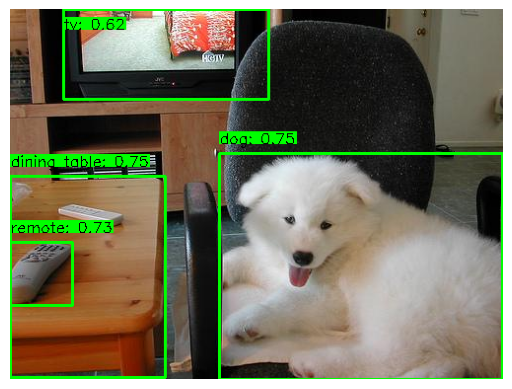

In [5]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Khởi tạo mô hình YOLOv8
model = YOLO('yolov8n.pt')  # Phiên bản nhẹ của YOLOv8, có thể thay đổi nếu cần

# Đọc ảnh từ thư mục input của Kaggle
image_path = '/kaggle/input/dog-stanford/public_dataset/train/images/n02111889-Samoyed/n02111889_108.jpg'  # Đường dẫn tới ảnh
image = cv2.imread(image_path)

# Chuyển ảnh sang RGB vì OpenCV đọc ảnh dưới dạng BGR
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Dự đoán đối tượng trong ảnh
results = model(image_rgb)

# Vẽ bounding box lên ảnh
for result in results:
    boxes = result.boxes  # Lấy bounding box
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Tọa độ bounding box
        label = model.names[int(box.cls)]  # Lớp dự đoán
        confidence = float(box.conf)  # Chuyển đổi sang kiểu float

        # Hiển thị nhãn nếu confidence > 0.5
        if confidence > 0.5:
            # Vẽ rectangle cho bounding box
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Xác định vị trí nhãn để tránh bị khuất
            text = f'{label}: {confidence:.2f}'
            text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            text_x, text_y = x1, y1 - 10 if y1 > 20 else y1 + 20

            # Vẽ nền mờ cho nhãn để dễ đọc hơn
            cv2.rectangle(image_rgb, (text_x, text_y - text_size[1]), 
                          (text_x + text_size[0], text_y), (0, 255, 0), -1)

            # Vẽ nhãn và độ tin cậy với kích thước chữ nhỏ hơn
            cv2.putText(image_rgb, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

# Hiển thị ảnh với matplotlib trên Kaggle
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


# DeepLab V3+

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 212MB/s] 


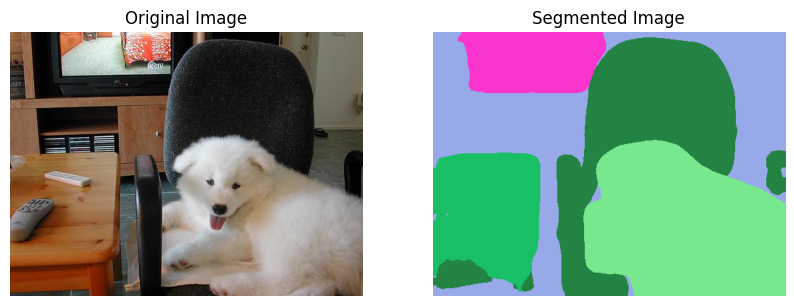

In [6]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models

# Khởi tạo mô hình DeepLabV3 với backbone ResNet-101
model = models.segmentation.deeplabv3_resnet101(weights="COCO_WITH_VOC_LABELS_V1").eval()

# Đường dẫn đến ảnh 
image_path = '/kaggle/input/dog-stanford/public_dataset/train/images/n02111889-Samoyed/n02111889_108.jpg'
image = Image.open(image_path).convert("RGB")

# Tiền xử lý ảnh
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(image).unsqueeze(0)  # Thêm batch dimension

# Dự đoán phân đoạn
with torch.no_grad():
    output = model(input_tensor)['out'][0]
output_predictions = output.argmax(0).byte().cpu().numpy()

# Tạo một colormap ngẫu nhiên với nhiều màu
num_classes = output_predictions.max() + 1  # Số lớp tối đa trong dự đoán
colormap = np.random.randint(0, 255, (num_classes, 3), dtype=np.uint8)

# Áp dụng colormap vào dự đoán
segmented_image = colormap[output_predictions]

# Vẽ kết quả phân đoạn
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Segmented Image")
plt.axis("off")
plt.show()


# Neural Style Transfer with transfer learning

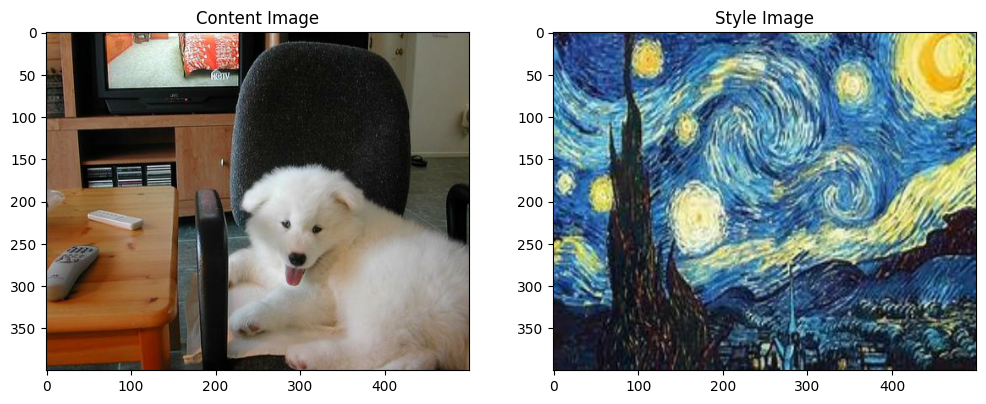

In [7]:
# Thư viện
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time
import functools
import matplotlib as mpl

# Thiết lập cấu hình cho matplotlib (kích thước hình ảnh và ẩn lưới trong biểu đồ)
mpl.rcParams['figure.figsize'] = (12, 12)  # Đặt kích thước cho hình ảnh hiển thị
mpl.rcParams['axes.grid'] = False  # Ẩn lưới trong các biểu đồ

# Đường dẫn đến các hình ảnh
style_image_path = '/kaggle/input/style-image/starry_night.jpg'  # Đường dẫn đến ảnh phong cách
content_image_path = '/kaggle/input/dog-stanford/public_dataset/train/images/n02111889-Samoyed/n02111889_108.jpg'  # Đường dẫn đến ảnh nội dung

# Hàm chuyển đổi tensor sang hình ảnh
def tensor_to_image(tensor):
    tensor = tensor * 255  # Chuyển đổi tensor sang phạm vi 0-255 (chuẩn hóa)
    tensor = np.array(tensor, dtype=np.uint8)  # Đổi tensor thành mảng numpy với kiểu uint8
    if np.ndim(tensor) > 3:  # Nếu tensor có nhiều hơn 3 chiều
        assert tensor.shape[0] == 1  # Kiểm tra đảm bảo tensor có batch size là 1
        tensor = tensor[0]  # Lấy tensor đầu tiên trong batch
    return PIL.Image.fromarray(tensor)  # Chuyển đổi thành đối tượng ảnh PIL

# Hàm tải hình ảnh
def load_image(path_to_image):
    img = tf.io.read_file(path_to_image)  # Đọc hình ảnh từ đường dẫn
    img = tf.image.decode_image(img, channels=3)  # Giải mã hình ảnh với 3 kênh màu (RGB)
    img = tf.image.convert_image_dtype(img, tf.float32)  # Chuyển đổi dữ liệu ảnh sang kiểu float32
    img = tf.image.resize(img, (400, 500))  # Thay đổi kích thước ảnh thành 400x500
    img = img[tf.newaxis, :]  # Thêm chiều batch cho ảnh
    return img

# Hàm hiển thị hình ảnh với tiêu đề
def imshow(image, title):
    if len(image.shape) > 3:  # Nếu hình ảnh có nhiều hơn 3 chiều
        image = tf.squeeze(image, axis=0)  # Loại bỏ chiều batch
    plt.imshow(image)  # Hiển thị hình ảnh
    plt.title(title)  # Đặt tiêu đề cho hình ảnh

# Tải và hiển thị hình ảnh
content_image = load_image(content_image_path)  # Tải ảnh nội dung
style_image = load_image(style_image_path)  # Tải ảnh phong cách

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')  # Hiển thị ảnh nội dung

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')  # Hiển thị ảnh phong cách


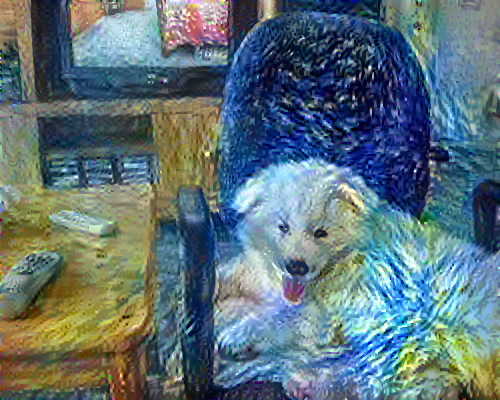

Step: 1000


In [8]:
# Hàm tạo các lớp của mô hình VGG
def vgg_layers(layers):
    # Tải mô hình VGG19 mà không có phần đầu (include_top=False) và sử dụng trọng số từ ImageNet
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    # Không cho phép huấn luyện lại các lớp của VGG
    vgg.trainable = False
    # Lấy các đầu ra từ các lớp đã chỉ định
    outputs = [vgg.get_layer(layer).output for layer in layers]
    # Tạo mô hình mới với đầu vào là đầu vào của VGG và đầu ra là các lớp đã chọn
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Xác định các lớp nội dung và phong cách
content_layers = ['block5_conv2']
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

# Đếm số lớp nội dung và phong cách
num_content_layers = len(content_layers)
num_style_layers   = len(style_layers)

# Hàm tính ma trận Gram
def gram_matrix(input_tensor):
    # Tính ma trận Gram bằng phép nhân ma trận
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    # Trả về ma trận Gram đã chuẩn hóa
    return result/(num_locations)

# Lớp mô hình kết hợp phong cách và nội dung
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        # Tạo mô hình VGG cho các lớp phong cách và nội dung
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        # Không cho phép huấn luyện lại mô hình VGG
        self.vgg.trainable = False

    def call(self, inputs):
        # Đưa dữ liệu vào khoảng [0, 255] và chuẩn hóa theo cách của VGG
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        # Lấy đầu ra từ mô hình VGG
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

        # Tính toán ma trận Gram cho các đầu ra phong cách
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        # Tạo từ điển cho các đầu ra nội dung và phong cách
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

# Khởi tạo mô hình để trích xuất phong cách và nội dung
extract = StyleContentModel(style_layers, content_layers)
# Lưu các giá trị mục tiêu cho phong cách và nội dung
style_targets   = extract(style_image)['style']
content_targets = extract(content_image)['content']

# Biến cho hình ảnh đầu ra
image = tf.Variable(content_image)

# Hàm giới hạn giá trị của hình ảnh trong khoảng [0, 1]
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Khởi tạo tối ưu hóa Adam
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Trọng số cho mất mát phong cách và nội dung
style_weight   = 1e-2
content_weight = 1e4

# Hàm tính toán mất mát phong cách và nội dung
def style_content_loss(outputs):
    style_outputs   = outputs['style']
    content_outputs = outputs['content']

    # Tính mất mát phong cách
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    # Tính mất mát nội dung
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    # Tổng hợp mất mát
    loss = style_loss + content_loss
    return loss

# Trọng số cho biến tổng thể
total_variation_weight = 30

# Hàm huấn luyện từng bước
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extract(image)
        # Tính toán mất mát
        loss = style_content_loss(outputs)
        # Cộng thêm biến tổng thể vào mất mát
        loss += total_variation_weight * tf.image.total_variation(image)

    # Tính gradient và cập nhật hình ảnh
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

# Sử dụng tqdm để theo dõi quá trình huấn luyện
from tqdm.auto import tqdm
epochs = 10  # Số epoch huấn luyện
steps_per_epoch = 100  # Số bước trong mỗi epoch
image = tf.Variable(content_image)  # Khởi tạo lại hình ảnh
step = 0  # Khởi tạo biến đếm bước

# Vòng lặp huấn luyện
for n in tqdm(range(epochs)):
    for m in tqdm(range(steps_per_epoch)):
        step += 1
        train_step(image)  # Thực hiện một bước huấn luyện
        print("¯\_(ツ)_/¯", end='')  # In một biểu tượng để hiển thị tiến trình
    display.clear_output(wait=True)  # Xóa đầu ra cũ
    display.display(tensor_to_image(image))  # Hiển thị hình ảnh hiện tại
    print("Step: {}".format(step))  # In số bước hiện tại
